In [3]:
import zipfile
# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [4]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [6]:
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In [12]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [29]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [10]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [13]:
def create_model(model_url, num_classes=10):
    """Takes a tensorflow hub url and creates a keras sequential model with it.

    Args:
        model_url (str): A tensorflow hub feature extraction Url.
        num_classes(int): number of output neurons/number of target classes.

    Returns:
        An uncompiled keras sequential model with model_url as feature extractor layer adn dense output layer
        with num_classes output neurons
    """

    feature_extractor_layer = hub.KerasLayer(model_url, trainable=False, 
                                             name="feature_extraction_layer",
                                             input_shape=IMAGE_SHAPE + (3,))    
    

    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation = 'softmax', name='output_layer')
    ])

    return model

In [14]:
train_data_10_percent.num_classes

10

In [24]:
# creating and testing resnet tensorflow Hub feture extraction
resnet_model = create_model(resnet_url, train_data_10_percent.num_classes)

In [25]:
# compile resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.legacy.Adam(),
                     metrics=['accuracy'])

In [26]:
resnet_history = resnet_model.fit(train_data_10_percent, # use augmented data
                          epochs=5,
                          steps_per_epoch=len(train_data_10_percent),
                          validation_data=test_data,
                          validation_steps=len(test_data),
                          callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                experiment_name="resnet50v2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20231106-002409
Epoch 1/5
24/24 [==============================] - 50s 2s/step - loss: 1.7975 - accuracy: 0.4120 - val_loss: 1.1700 - val_accuracy: 0.6332
Epoch 2/5
24/24 [==============================] - 29s 1s/step - loss: 0.8729 - accuracy: 0.7440 - val_loss: 0.8551 - val_accuracy: 0.7256
Epoch 3/5
24/24 [==============================] - 32s 1s/step - loss: 0.6181 - accuracy: 0.8213 - val_loss: 0.7529 - val_accuracy: 0.7544
Epoch 4/5
24/24 [==============================] - 30s 1s/step - loss: 0.4690 - accuracy: 0.8827 - val_loss: 0.7172 - val_accuracy: 0.7748
Epoch 5/5
24/24 [==============================] - 29s 1s/step - loss: 0.3814 - accuracy: 0.9173 - val_loss: 0.6888 - val_accuracy: 0.7756


In [30]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

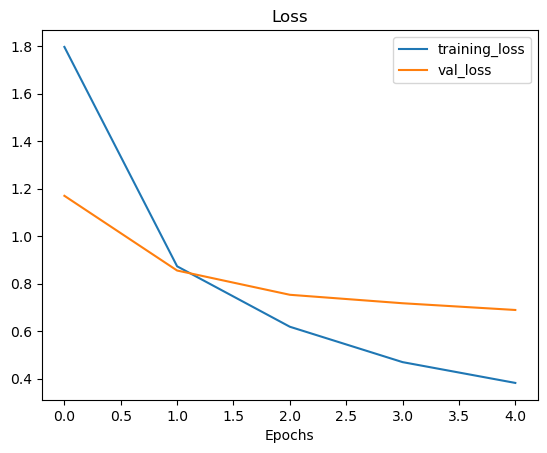

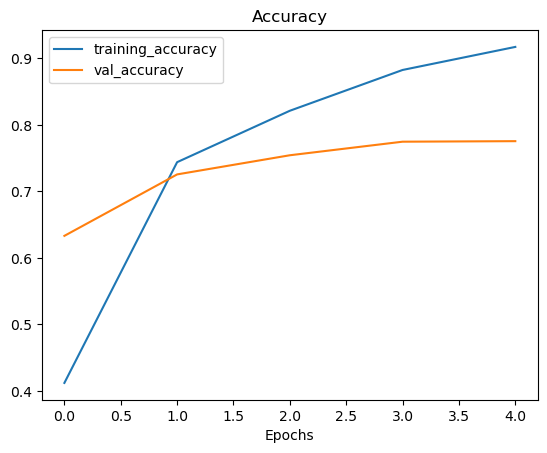

In [31]:
plot_loss_curves(resnet_history)

In [32]:
# creating efficieNetB0
efficientnet_model = create_model(efficientnet_url, train_data_10_percent.num_classes)

efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.legacy.Adam(),
                     metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(train_data_10_percent, # use augmented data
                          epochs=5,
                          steps_per_epoch=len(train_data_10_percent),
                          validation_data=test_data,
                          validation_steps=len(test_data),
                          callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                experiment_name="efficientNetB0")])
                                              

Saving TensorBoard log files to: tensorflow_hub/efficientNetB0/20231106-003425
Epoch 1/5
24/24 [==============================] - 72s 2s/step - loss: 1.8521 - accuracy: 0.4467 - val_loss: 1.3053 - val_accuracy: 0.7240
Epoch 2/5
24/24 [==============================] - 22s 946ms/step - loss: 1.0591 - accuracy: 0.7813 - val_loss: 0.8670 - val_accuracy: 0.8156
Epoch 3/5
24/24 [==============================] - 22s 932ms/step - loss: 0.7536 - accuracy: 0.8453 - val_loss: 0.6954 - val_accuracy: 0.8444
Epoch 4/5
24/24 [==============================] - 21s 920ms/step - loss: 0.6022 - accuracy: 0.8680 - val_loss: 0.6069 - val_accuracy: 0.8616
Epoch 5/5
24/24 [==============================] - 21s 916ms/step - loss: 0.5067 - accuracy: 0.8933 - val_loss: 0.5527 - val_accuracy: 0.8736


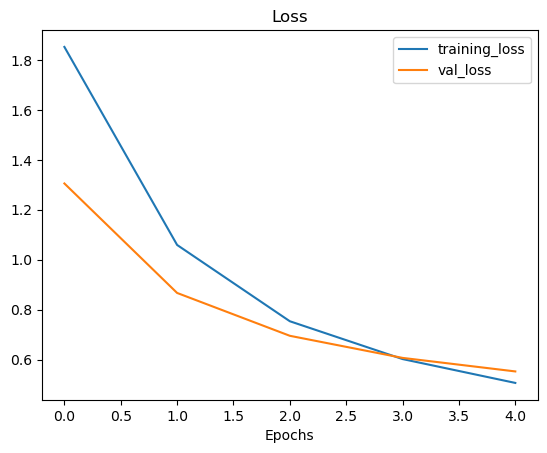

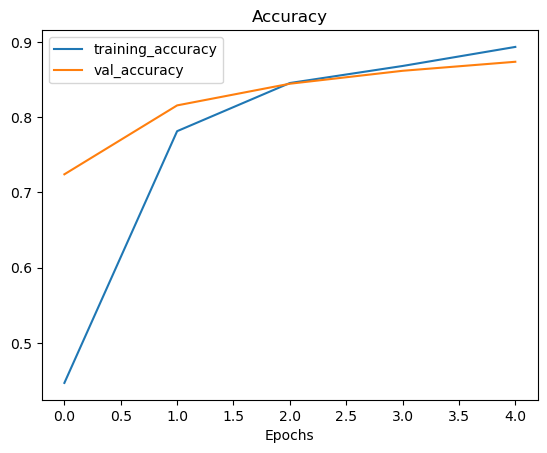

In [33]:
plot_loss_curves(efficientnet_history)